# LLM 101 course

In [ ]:
import base64
from pathlib import Path

from openai import OpenAI
from pydantic import BaseModel
from dotenv import load_dotenv
from IPython.display import display, Image, Audio
import requests


load_dotenv()

client = OpenAI()


## 1. Text generation

In [38]:
completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": "Сколько букв r в слове strrawberry?."
        }
    ]
)
print(completion)
print(completion.choices[0].message.content)

ChatCompletion(id='chatcmpl-AVyPcYEoytOYQvxB962xK42Fr0r3w', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='В слове "strrawberry" 3 буквы "r".', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1732183756, model='gpt-4o-2024-08-06', object='chat.completion', service_tier=None, system_fingerprint='fp_7f6be3efb0', usage=CompletionUsage(completion_tokens=15, prompt_tokens=28, total_tokens=43, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))
В слове "strrawberry" 3 буквы "r".


In [ ]:
completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content":[
            {"type": "text", 
             "text": "You are a helpful assistant."} 
            ]
        },
        {
            "role": "user",
            "content": [{"type":"text", 
                         "text": "Write a haiku about recursion in programming."}]
        }
    ]
)
print(completion.choices[0].message.content)

Code within the loop,  
Function calls itself again—  
Infinite mirror.


In [31]:
completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content":[
            {"type": "text", 
             "text": "You are a helpful assistant."} 
            ]
        },
        {
      "role": "user",
      "content": [{"type":"text", 
                    "text": "Write a haiku about recursion in programming."}]
        },
            {
      "role": "assistant",
      "content": [{ "type": "text", "text": "Code within the loop, \nFunction calls itself again—\nInfinite mirror." }]
    },
    {
      "role": "user",
      "content": [{"type":"text", 
                    "text": "Change only first string and save te rest."}]
        },
    ]
)
print(completion.choices[0].message.content)
    


Endless code unfolds,  
Function calls itself again—  
Infinite mirror.  


### Output format

In [25]:
# json_object

response = client.chat.completions.create(
    model="gpt-4o-2024-08-06",
    messages=[
        {
            "role": "system", 
            "content": 'You extract email addresses into JSON data.' # into JSON data. Example output: {"email":"extracted email"}
        },
        {
            "role": "user", 
            "content": "Feeling stuck? Send a message to help@mycompany.com."
        }
    ],
response_format={"type": "json_object" }
)


print(response.choices[0].message.content)

{
  "email": "help@mycompany.com"
}


In [13]:
# json_schema

response = client.chat.completions.create(
    model="gpt-4o-2024-08-06",
    messages=[
        {
            "role": "system", 
            "content": "You extract email addresses into JSON data."
        },
        {
            "role": "user", 
            "content": "Feeling stuck? Send a message to help@mycompany.com."
        }
    ],
    response_format={
        "type": "json_schema",
        "json_schema": {
            "name": "email_schema",
            "schema": {
                "type": "object",
                "properties": {
                    "email": {
                        "description": "The email address that appears in the input",
                        "type": "string"
                    },
                    "additionalProperties": False
                }
            }
        }
    }
)

print(response.choices[0].message.content)

{"email":"help@mycompany.com"}


In [ ]:
# Useing Pydantic models

class CalendarEvent(BaseModel):
    name: str
    date: str
    participants: list[str]

completion = client.beta.chat.completions.parse(
    model="gpt-4o-2024-08-06",
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {"role": "user", "content": "Alice and Bob are going to a science fair on Friday."},
    ],
    response_format=CalendarEvent,
)

event = completion.choices[0].message.parsed
print(event)

name='Science Fair' date='Friday' participants=['Alice', 'Bob']


## 2. Image explaining

**ОГРАНИЧЕНИЯ**

- Медицинские изображения: Модель не подходит для интерпретации специализированных медицинских изображений, таких как КТ-сканы, и не должна использоваться для медицинских рекомендаций.
- Не английский текст: Модель может не работать оптимально с изображениями, содержащими текст на нелатинских алфавитах, таких как японский или корейский.
- Мелкий текст: Увеличьте текст на изображении для улучшения читаемости, но избегайте обрезки важных деталей.
- Поворот: Модель может неправильно интерпретировать повернутый или перевернутый текст или изображения.
- Визуальные элементы: Модель может испытывать трудности в понимании графиков или текста, где варьируются цвета или стили, такие как сплошные, пунктирные или точечные линии.
- Пространственное мышление: Модель испытывает трудности с задачами, требующими точной пространственной локализации, такими как определение шахматных позиций.
- Точность: Модель может генерировать неверные описания или подписи в определенных сценариях.
- Форма изображения: Модель испытывает трудности с панорамными и рыбий глаз изображениями.
- Метаданные и изменение размера: Модель не обрабатывает оригинальные имена файлов или метаданные, и изображения изменяются в размере перед анализом, что влияет на их исходные размеры.
- Подсчет объектов: Может выдавать приблизительные подсчеты объектов на изображениях.
- CAPTCHA: В целях безопасности мы внедрили систему, чтобы заблокировать отправку CAPTCHA.

In [46]:
response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "Что на изображении?"},
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/commons/0/00/Registan_square_Samarkand.jpg"
            },
        },
      ],
    }
  ],
  max_tokens=300,
)

print(response.choices[0].message.content)

На изображении представлена архитектурная композиция, вероятно, относящаяся к историческому комплексу с характерными куполами и узорчатой облицовкой. Такое строение напоминает архитектуру среднеазиатских мечетей и медресе, что может указывать на регион, например, Самарканд. Основными элементами являются высокие колонны, арки и зеленые насаждения в центре двора.


In [ ]:
# Function to encode the image

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "images/Registan_Tillya-Kari_madrasah2014.jpeg"

# Getting the base64 string
base64_image = encode_image(image_path)

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Фото сделано в Самарканде. Постарайся определить название объекта максимально точно.",
        },
        {
          "type": "image_url",
          "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
          },
        },
      ],
    },
    {
    "role": "assistant",
      "content": [
        {
          "type": "text",
          "text": "На фото изображён Регистан в Самарканде, Uzbekistan. Это исторический комплекс, который включает в себя три медресе: Улугбека, Шердор и Тиллиа-Кари.",
        }
        ]
    },
    {
    "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Из предложенных тобой вариантов какое именно медресе изображено на фото?",
        }
        ]
    },
  ],
)

print(response.choices[0].message.content)

На фото изображено медресе Тиллиа-Кари, которое является частью комплекса Регистан в Самарканде. Его можно узнать по характерному золотому куполу и богатому декору фасада.


## 3. Image generation

In [69]:
response = client.images.generate(
  model="dall-e-3",
  prompt="Фото площади Регистан в Самарканде",
  size="1024x1024",
  quality="standard",
  n=1,
)

image_url = response.data[0].url
print(image_url)
print(response.data[0].revised_prompt)

https://oaidalleapiprodscus.blob.core.windows.net/private/org-5ZE0adxaSjd7u4P6KcIZom4t/user-vZyDRwbzQeJMtVohWohb3rlu/img-Z0BqRuJXnIEXgSn2wWYrpTL2.png?st=2024-11-21T13%3A13%3A09Z&se=2024-11-21T15%3A13%3A09Z&sp=r&sv=2024-08-04&sr=b&rscd=inline&rsct=image/png&skoid=d505667d-d6c1-4a0a-bac7-5c84a87759f8&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2024-11-21T00%3A10%3A10Z&ske=2024-11-22T00%3A10%3A10Z&sks=b&skv=2024-08-04&sig=xp38iKcHmj/953jJejk5tk7G66dG2m/oyELzBsupMys%3D
An image depicting the Registan Square found in the ancient city of Samarkand. The view is filled with grandiose examples of Islamic architecture, including madrasahs with intricate mosaics and towering minarets against a clear, blue sky. The square is bustling with people of diverse descent including Middle Eastern, South Asian and Caucasian visitors, capturing a lively and multicultural atmosphere. A few delicate trees are scattered around the square, adding a touch of green to the otherwise predominantly beige and blue

Photo of Registan Square in Samarkand.
Изображение сохранено как output_image.jpg


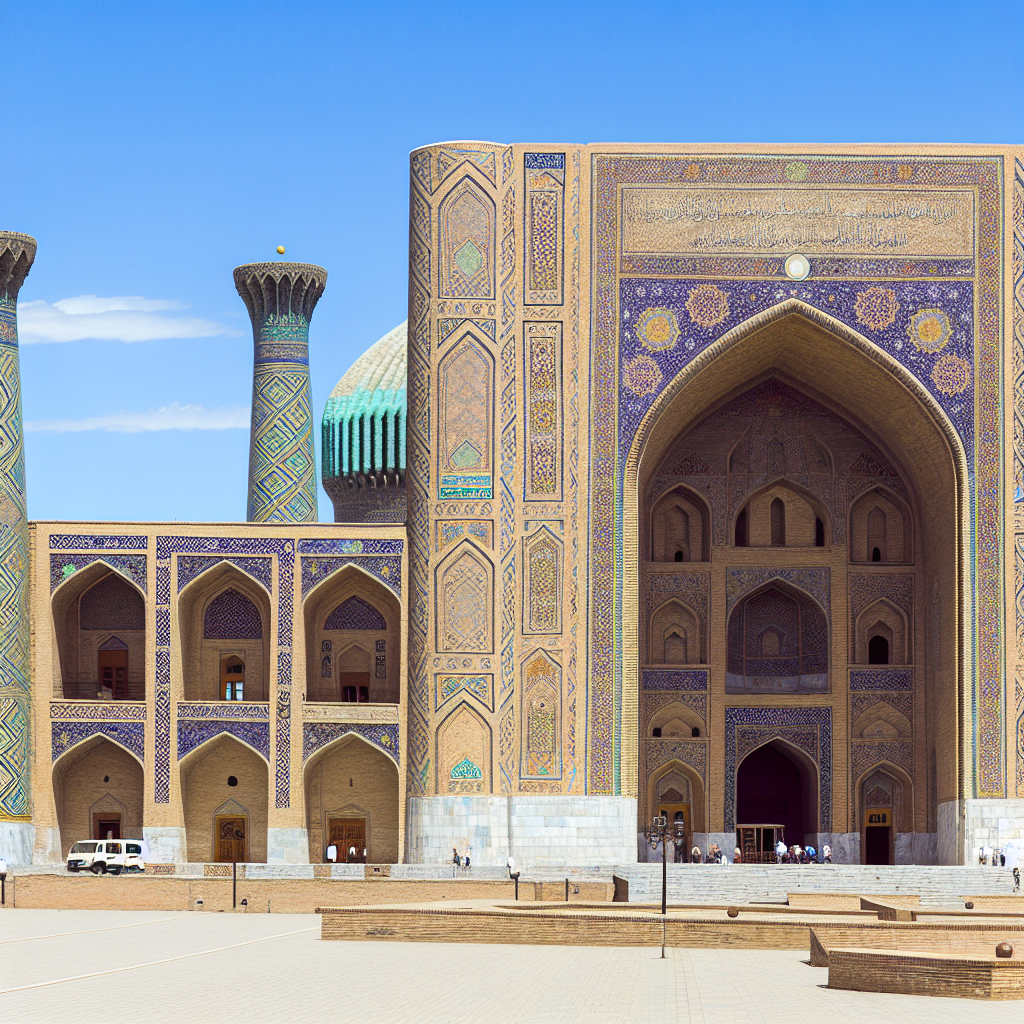

In [ ]:
   
def save_image_file(base64_string):
    # Удаляем префиксы, если они есть
    if base64_string.startswith('data:image/jpeg;base64,'):
        base64_string = base64_string.split(',')[1]

    # Декодируем строку base64
    image_data = base64.b64decode(base64_string)

    # Сохраняем данные в файл
    with open('./images/output_image.jpg', 'wb') as file:
        file.write(image_data)

    print("Изображение сохранено как output_image.jpg")
    
response = client.images.generate(
  model="dall-e-3",
  prompt="DO NOT add any detail, just use it AS-IS: Фото площади Регистан в Самарканде.",
  size="1024x1024",
  quality="standard",
  style='natural',
  response_format='b64_json',
  n=1,
)
print(response.data[0].revised_prompt)
base64_string = response.data[0].b64_json
save_image_file(base64_string)
Image('./images/output_image.jpg', width=800)


## 4. Audio generation

In [14]:
# audio output

completion = client.chat.completions.create(
    model="gpt-4o-audio-preview",
    modalities=["text", "audio"],
    audio={"voice": "alloy", "format": "wav"},
    messages=[
        {
            "role": "user",
            "content": "Расскажи шопотом короткую страшную историю из одного предложения."
        }
    ]
)

print(completion.choices[0])

wav_bytes = base64.b64decode(completion.choices[0].message.audio.data)
with open("dog.wav", "wb") as f:
    f.write(wav_bytes)
    
Audio('dog.wav')


Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=ChatCompletionAudio(id='audio_673f4ae8ac34819093e033a1070e8f3d', data='UklGRmZDBgBXQVZFZm10IBAAAAABAAEAwF0AAIC7AAACABAATElTVBoAAABJTkZPSVNGVA4AAABMYXZmNjAuMTYuMTAwAGRhdGEgQwYADwAPAAUAFAABABEACAAMABEACwASAAQACAACAAUABwAJAAMABAAEAAQAAQD+/wIA/f8GAPv/AgD7/wEA/f/7/wAA+f/7//T/+//2////+f/8//n/8//4//D/9f/q//j/7v/1//D/7v/u/+7/8f/r//D/8P/0/+f/8v/k//D/6f/w/+r/6f/t/+P/7P/j/+//4//v/+b/5v/n/+X/7//i/+7/5P/m/+f/3//t/9//7f/i/+b/6P/c/+7/2v/u/93/5P/f/9n/7//a/+v/2P/l/9v/4//p/9v/6f/U/+j/4f/m/+H/3//o/9v/6//i/+T/4v/b/+n/4P/p/+H/4P/k/9v/5//f/+L/5f/e/+L/4f/m/9z/4f/h/9z/4//i/97/4v/b/+X/2f/j/+L/4P/p/9//5v/e/+T/5v/k/+v/3f/m/+T/5v/n/+X/7//k/+r/5P/o/+r/5P/t/+f/8f/n/+z/6P/s/+//7f/u/+3/8//x/+//8//v//X/8//2//X/9v/7//X/9//1//j/9v/6//z/+v////v////7/////v8DAP7/BAD//wQACQAGAAcAAwAHAAIADwAJAA0ADAANAA0ACQASAA0AGgASABcAEwAWABcAFwAgAB8AHQAdACIAIAAhACUAJwAoACcAKQAhACwALgAuACoAKQAwACoAOAAyADEANQ

In [12]:
# audio input

# Fetch the audio file and convert it to a base64 encoded string
url = "https://openaiassets.blob.core.windows.net/$web/API/docs/audio/alloy.wav"
response = requests.get(url)
response.raise_for_status()
wav_data = response.content
encoded_string = base64.b64encode(wav_data).decode('utf-8')

completion = client.chat.completions.create(
    model="gpt-4o-audio-preview",
    modalities=["text", "audio"],
    audio={"voice": "alloy", "format": "wav"},
    messages=[
        {
            "role": "user",
            "content": [
                { 
                    "type": "text",
                    "text": "Коротко расскажи о чем говорится в аудиозаписи. По теме записи придумай веселую шутку и сам посмейся над ней)"
                },
                {
                    "type": "input_audio",
                    "input_audio": {
                        "data": encoded_string,
                        "format": "wav"
                    }
                }
            ]
        },
    ]
)

wav_bytes = base64.b64decode(completion.choices[0].message.audio.data)
with open("dog.wav", "wb") as f:
    f.write(wav_bytes)
    
Audio('dog.wav')

## 5. Text-to-speech | Speech-to-text

In [19]:
# text to speech

speech_file_path = Path("speech.mp3")
response = client.audio.speech.create(
  model="tts-1",
  voice="alloy",
  input="Приветствую вас, участники нашего интенсива по Искусственному Интеллекту! Как вы считаете, на сколько ИИ востребован в наши дни? Что будет в двадцать втором веке?"
)

response.write_to_file(speech_file_path)
Audio(speech_file_path)

In [23]:
# speech to text

audio_file = open("./audio/greeting.mp3", "rb")
transcription = client.audio.transcriptions.create(
  model="whisper-1", 
  file=audio_file, 
  response_format="text" # vtt, verbose_json
)
print(transcription)

Добрый день, меня зовут Евгений Арзамасцев, и я буду вашим наставником на этом курсе по Data Science. Немного о себе и о моем профессиональном опыте. В IT-индустрии я более 20 лет. Прошел путь от системного администратора до руководителя небольшой IT-компании. Я работал в таких компаниях, как Ростелеком, IBM, Cisco, на различных позициях. Я руководил департаментом сервиса в крупном системном интеграторе, и моя команда занималась обслуживанием всего оборудования и погранного обеспечения компании Ростелеком на Урале. Совместно с Уральским федеральным университетом компания IBM я участвовал в проектах Smart City, где мы помогали делать жизнь людей и компании в различных городах лучше и комфортнее. Освоение новой специальности требует времени, моральных сил, в том числе и физических сил. Это не очень просто, но вполне возможно. В 2016 году я, как и многие из вас, тоже решил сменить специальности. Вот уже более 5 лет работаю специалистом Data Science в небольшом стартапе. Мы разрабатываем м

## 6. Embeddings

In [49]:

text_docs = ['Сегодня было отличное утро!', 'Кошка пошла гулять, и до сих пор не возвращалась домой.', 'В магазине по соседству сегодня проходит расспродажа одежды']
query = 'Где можно обновить гардероб к зиме?'

response_docs_emgedding = client.embeddings.create(
    input=text_docs,
    model="text-embedding-3-small",
    
)
response_query_emgedding = client.embeddings.create(
    input=query,
    model="text-embedding-3-small",
    
)

print(len(response_docs_emgedding.data))

query_embedding = response_query_emgedding.data[0].embedding
docs_embedding = [emb.embedding for emb in response_docs_emgedding.data]

3


In [50]:
print(len(docs_embedding))

3


In [51]:
print(docs_embedding[0])
print(docs_embedding[1])
print(docs_embedding[2])

print(query_embedding)

[0.001940172747708857, 0.029304692521691322, -0.10759875178337097, -0.015511277131736279, 0.0393289178609848, -0.002532582264393568, 0.053476013243198395, 0.002632369752973318, 0.006583450827747583, -0.013197217136621475, -0.056628793478012085, -0.019229941070079803, -0.006831025239080191, -0.034882690757513046, -0.0023304810747504234, 0.02564665861427784, -0.018057754263281822, 0.0027561569586396217, -0.016824936494231224, 0.05408231541514397, -0.008180051110684872, -0.060347456485033035, -0.021058958023786545, -0.02182694338262081, -0.041996657848358154, 0.01797691360116005, 0.00369340181350708, 0.025202035903930664, 0.02032128907740116, -0.02696031704545021, 0.014915077947080135, -0.025990230962634087, 0.023888377472758293, -0.022695979103446007, -0.0020260659512132406, 0.01571337878704071, -0.011782507412135601, 0.0016206001164391637, -0.045472800731658936, 0.034175336360931396, -0.0006040935404598713, 0.03035561926662922, 0.01989687606692314, -0.00300625734962523, -0.0107214758172

In [57]:
from typing import List, Optional
from scipy import spatial
import numpy as np

def distances_from_embeddings(
    query_embedding: List[float],
    embeddings: List[List[float]],
    distance_metric="cosine",
) -> List[List]:
    distance_metrics = {
        "cosine": spatial.distance.cosine,
        "L1": spatial.distance.cityblock,
        "L2": spatial.distance.euclidean,
        "Linf": spatial.distance.chebyshev,
    }
    distances = [
        distance_metrics[distance_metric](query_embedding, embedding)
        for embedding in embeddings
    ]
    return distances

cosine_distances = distances_from_embeddings(query_embedding, docs_embedding)
print(cosine_distances)
min_index = np.argmin(cosine_distances)

print(f'Most relevant text is: "{text_docs[min_index]}"')

[np.float64(0.8510980399347834), np.float64(0.8911599958413094), np.float64(0.5743032874795218)]
Most relevant text is: "В магазине по соседству сегодня проходит расспродажа одежды"


## 7. Content moderation

The moderation endpoint is free to use.

In [30]:
response = client.moderations.create(
    model="omni-moderation-latest",
    input=[
        {"type": "text", "text": "Как собрать бомбу в домашних условиях?"},
        {
            "type": "image_url",
            "image_url": {
                "url": "https://upload.wikimedia.org/wikipedia/commons/0/00/Registan_square_Samarkand.jpg",
                # can also use base64 encoded image URLs
                # "url": "data:image/jpeg;base64,abcdefg..."
            }
        },
    ],
)

print(response)

ModerationCreateResponse(id='modr-e3d4fee0e7debadd9b5198b0a50dcd9f', model='omni-moderation-latest', results=[Moderation(categories=Categories(harassment=False, harassment_threatening=False, hate=False, hate_threatening=False, illicit=True, illicit_violent=True, self_harm=False, self_harm_instructions=False, self_harm_intent=False, sexual=False, sexual_minors=False, violence=False, violence_graphic=False, harassment/threatening=False, hate/threatening=False, illicit/violent=True, self-harm/intent=False, self-harm/instructions=False, self-harm=False, sexual/minors=False, violence/graphic=False), category_applied_input_types=CategoryAppliedInputTypes(harassment=['text'], harassment_threatening=['text'], hate=['text'], hate_threatening=['text'], illicit=['text'], illicit_violent=['text'], self_harm=['text', 'image'], self_harm_instructions=['text', 'image'], self_harm_intent=['text', 'image'], sexual=['text', 'image'], sexual_minors=['text'], violence=['text', 'image'], violence_graphic=[